# Random forest model interpretation

## Imports and definitions

In [1]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from scipy.cluster import hierarchy as hc
from treeinterpreter import treeinterpreter as ti

from sklearn import metrics
import feather
import pdpbox.pdp as pdp
from plotnine import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
from contextlib import contextmanager

plt.rcParams["figure.figsize"] = (10, 6)
set_plot_sizes(12, 14, 16)
np.set_printoptions(precision=5)
pd.set_option("display.precision", 5)
%precision 5

# constants #################################################################
PATH = 'data/bulldozers/'
N_VALID = 12_000


# defines: ##################################################################
@contextmanager
def rf_samples(n='all', verbose=None):
    if isinstance(n, int) and n > 0:
        set_rf_samples(n)
        if verbose:
            print('set_rf_samples', n)
    try:
        yield
    finally:
        if isinstance(n, int) and n > 0:
            reset_rf_samples()
            if verbose:
                print('reset_rf_samples')


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns",
                           1000):
        display(df)


def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()


def rmse(x, y):
    return math.sqrt(((x - y)**2).mean())


def do_print_score(m, X_train, y_train, X_valid, y_valid):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_valid), y_valid),
        m.score(X_train, y_train),
        m.score(X_valid, y_valid),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(np.array(res))


class AttrDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


def do_proc_df(
        df_raw,
        n_valid,
        y_fld=None,
        skip_flds=None,
        ignore_flds=None,
        do_scale=False,
        na_dict=None,
        preproc_fn=None,
        max_n_cat=None,
        subset=None,
        mapper=None,
        to_keep=None,
):
    df_trn, y_trn, nas = proc_df(
        df=df_raw,
        y_fld=y_fld,
        skip_flds=skip_flds,
        ignore_flds=ignore_flds,
        do_scale=do_scale,
        na_dict=na_dict,
        preproc_fn=preproc_fn,
        max_n_cat=max_n_cat,
        subset=subset,
        mapper=mapper)
    if not (to_keep is None):
        df_trn = df_trn[to_keep]
    n_trn = len(df_trn) - n_valid
    X_train, X_valid = split_vals(df_trn, n_trn)
    y_train, y_valid = split_vals(y_trn, n_trn)
    raw_train, raw_valid = split_vals(df_raw, n_trn)
    return AttrDict(locals())


# variant with limited max_depth
def do_draw_tree(tree,
                 df,
                 max_depth=2,
                 size=10,
                 ratio=0.6,
                 precision=3,
                 rotate=True):
    s = export_graphviz(
        tree,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        special_characters=True,
        rotate=rotate,
        max_depth=max_depth,
        precision=precision,
    )
    display(
        graphviz.Source(
            re.sub("Tree {", f"Tree {{ size={size}; ratio={ratio}", s)))

In [2]:
!ls -al {DF_RAW_PATH}

ls: cannot access '{DF_RAW_PATH}': No such file or directory


## rf_reg_fit

In [3]:
# TODO: add param 'need_to_proc'
def rf_reg_fit(dattr,
               n_samples='all',
               n_estimators=10,
               min_samples_leaf=1,
               max_features='auto',
               oob_score=False,
               max_depth=None):
    with rf_samples(n_samples):
        print('samples:', n_samples)
        m = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            oob_score=oob_score,
            n_jobs=-1,
            max_depth=max_depth)
        m.fit(dattr.X_train, dattr.y_train)
    do_print_score(m, dattr.X_train, dattr.y_train, dattr.X_valid,
                   dattr.y_valid)
    dattr.m = m
    return dattr

## Load in our data from last lesson

In [4]:
DF_RAW = pd.read_feather('tmp/bulldozers-raw')
dattr01 = do_proc_df(DF_RAW, N_VALID, 'SalePrice')

# Confidence based on tree variance

In [5]:
fit01 = rf_reg_fit(
    dattr01,
    n_samples=50_000,
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.5,
    oob_score=True)

samples: 50000
[0.20609 0.24883 0.91123 0.88943 0.89419]


In [6]:
# tree variance check
preds = np.stack([t.predict(fit01.X_valid) for t in fit01.m.estimators_])
display(np.array([np.mean(preds[:, 0]), np.std(preds[:, 0])]))

array([9.27668, 0.33487])

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.84918,9.83876,0.28071
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.62397,10.57494,0.26874
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.68206,9.68483,0.22335


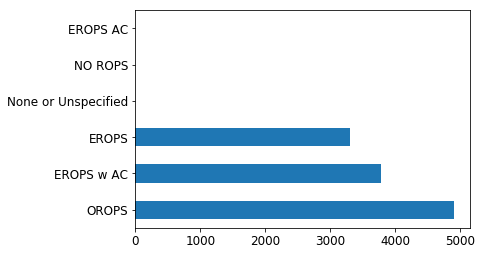

In [7]:
x01 = dattr01.raw_valid.copy()
x01['pred_std'] = np.std(preds, axis=0)
x01['pred'] = np.mean(preds, axis=0)
x01.Enclosure.value_counts().plot.barh();

flds01 = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ01 = x01[flds01].groupby('Enclosure', as_index=False).mean()
display(enc_summ01)
enc_summ01 = enc_summ01[~pd.isnull(enc_summ01.SalePrice)]

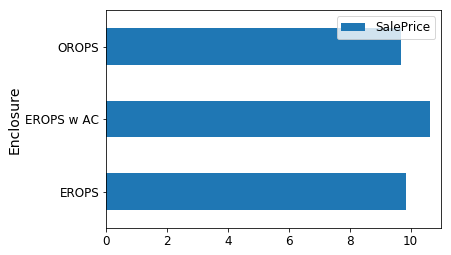

In [8]:
enc_summ01.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

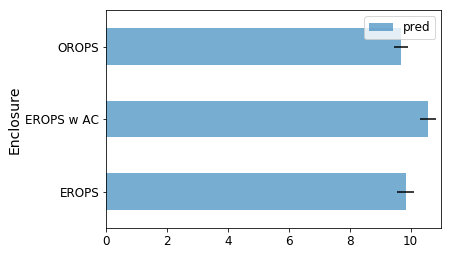

In [9]:
enc_summ01.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

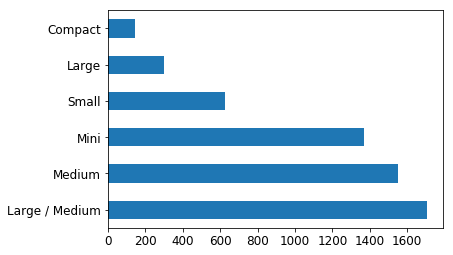

In [10]:
fit01.raw_valid.ProductSize.value_counts().plot.barh();

In [11]:
flds02 = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ02 = x01[flds02].groupby(flds02[0]).mean()
display(summ02)
display((summ02.pred_std/summ02.pred).sort_values(ascending=False))

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.73509,9.85160,0.35285
Large,10.47059,10.39455,0.37456
Large / Medium,10.69187,10.64350,0.30431
Medium,10.68151,10.62130,0.28709
Mini,9.53515,9.56238,0.25598
Small,10.32445,10.32517,0.31155


ProductSize
Large             0.03603
Compact           0.03582
Small             0.03017
Large / Medium    0.02859
Medium            0.02703
Mini              0.02677
dtype: float64

# Feature importance

In [12]:
fi01 = rf_feat_importance(fit01.m, fit01.df_trn); fi01[:10]

,cols,imp
5,YearMade,0.17176
37,Coupler_System,0.13088
13,ProductSize,0.09138
14,fiProductClassDesc,0.07825
2,ModelID,0.06135
63,saleElapsed,0.05052
39,Hydraulics_Flow,0.04609
10,fiSecondaryDesc,0.04223
19,Enclosure,0.03367
8,fiModelDesc,0.03184


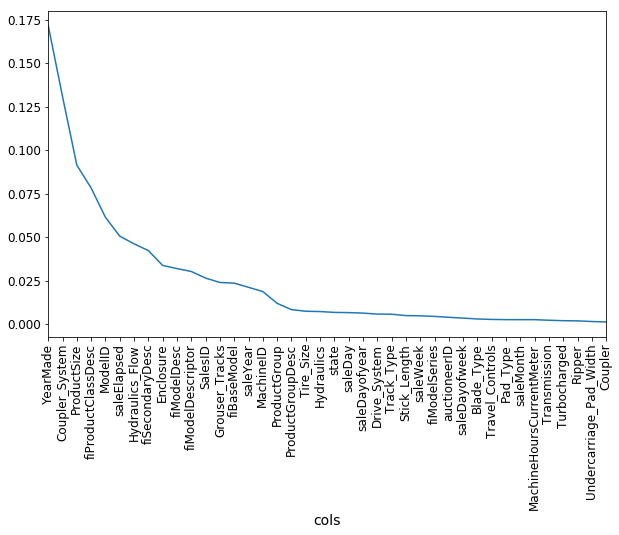

In [13]:
fi = fi01[:40]
fi.plot('cols', 'imp', figsize=(10,6), legend=False, kind='line')
plt.xticks(rotation=90);
plt.xticks(np.arange(0, fi.shape[0], 1), fi01.cols);

In [14]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

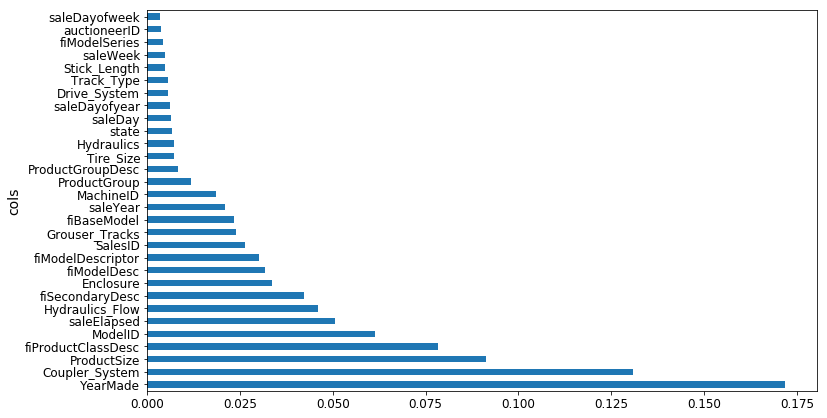

In [15]:
plot_fi(fi01[:30]);

In [16]:
to_keep01 = fi01[fi01.imp > 0.005].cols
to_keep01.shape

(25,)

In [17]:
dattr02 = do_proc_df(DF_RAW, N_VALID, y_fld='SalePrice', to_keep=to_keep01)
dattr02.df_trn.columns.shape

(25,)

In [18]:
fit02 = rf_reg_fit(
    dattr02,
    n_samples=50_000,
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.5,
    oob_score=True)

samples: 50000
[0.20718 0.24522 0.9103  0.89261 0.89399]


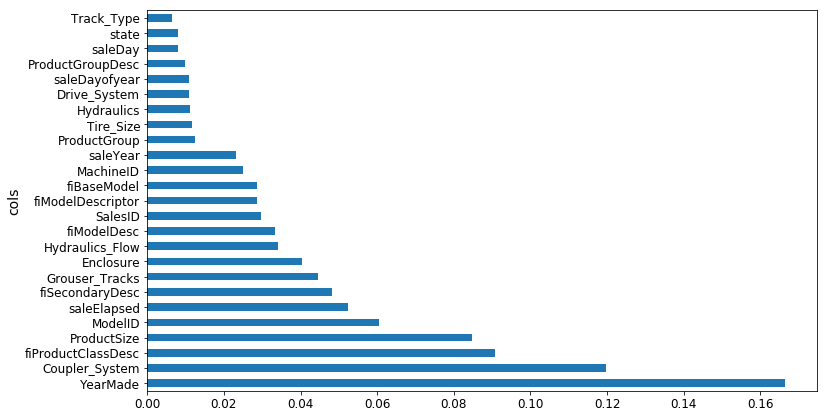

In [19]:
plot_fi(rf_feat_importance(fit02.m, fit02.df_trn));

## One-hot encoding

In [20]:
dattr03 = do_proc_df(DF_RAW, N_VALID, y_fld='SalePrice', max_n_cat=7)
fit03 = rf_reg_fit(
    dattr03,
    n_samples=50_000,
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.6,
    oob_score=True
)

samples: 50000
[0.2073  0.25337 0.91018 0.88536 0.89243]


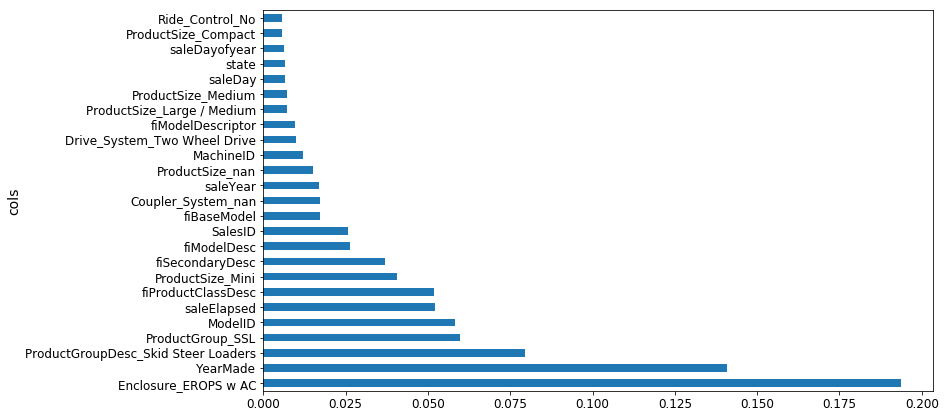

In [21]:
fi02 = rf_feat_importance(fit03.m, fit03.df_trn)
plot_fi(fi02[:25]);

# Removing redundant features

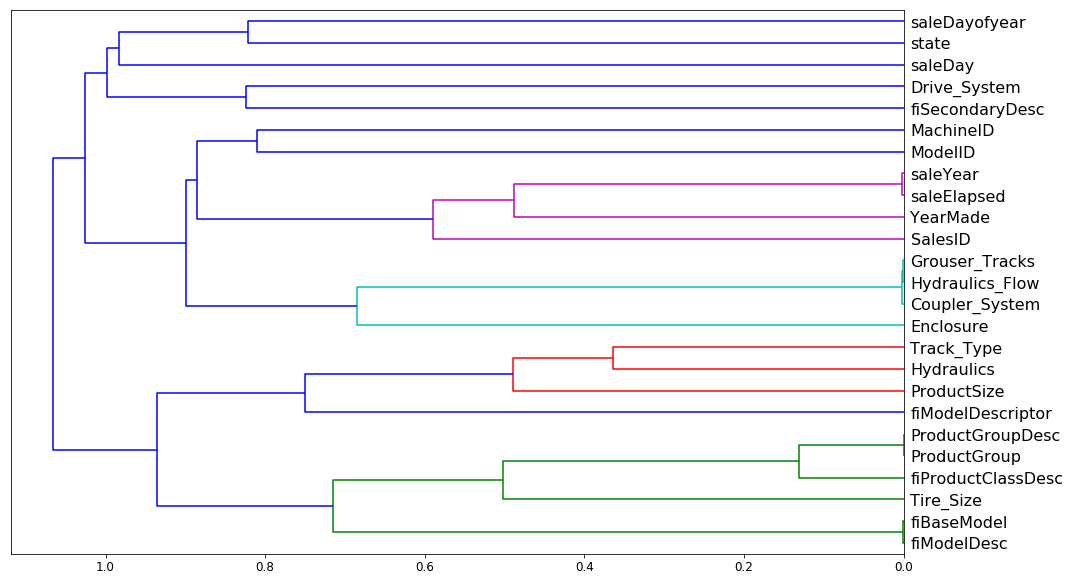

In [22]:
df_keep = dattr02.df_trn
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [23]:
def get_oob(X, y):
    with rf_samples(n=50_000):
        m = RandomForestRegressor(
            n_estimators=30,
            min_samples_leaf=5,
            max_features=0.6,
            n_jobs=-1,
            oob_score=True)
        m.fit(X, y)
    return m.oob_score_

In [24]:
# baseline
get_oob(dattr02.X_train, dattr02.y_train)

0.8898826297865402

In [25]:
# drop one at a time
df_keep = dattr02.X_train
for c in [
        'saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel',
        'Grouser_Tracks', 'Coupler_System'
]:
    print(c, get_oob(df_keep.drop(c, axis=1), dattr02.y_train))

saleYear 0.8897658118633913
saleElapsed 0.886884917947902
fiModelDesc 0.8891219635841229
fiBaseModel 0.8898999549381308
Grouser_Tracks 0.889865588451243
Coupler_System 0.8899359249021258


In [26]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
print(get_oob(dattr02.X_train.drop(to_drop, axis=1), dattr02.y_train))
np.save('tmp/keep_cols.npy', np.array(dattr02.X_train.drop(to_drop, axis=1).columns))

0.889106220175991


In [27]:
keep_cols = np.load('tmp/keep_cols.npy')
dattr04 = do_proc_df(DF_RAW, N_VALID, y_fld='SalePrice', to_keep=keep_cols)

In [28]:
fit04 = rf_reg_fit(
    dattr04,
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.5,
    oob_score=True)

samples: all
[0.12519 0.22615 0.96725 0.90866 0.9085 ]


# Partial dependence


In [29]:
dattr05 = do_proc_df(DF_RAW, N_VALID, y_fld='SalePrice', max_n_cat=7)

In [30]:
fit05 = rf_reg_fit(
    dattr05,
    n_samples=50_000,
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.6,
)

samples: 50000
[0.20705 0.25472 0.91041 0.88413]


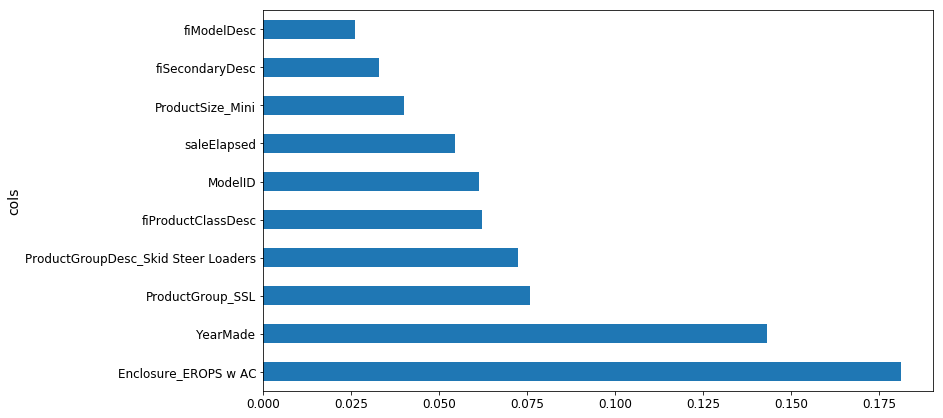

In [31]:
plot_fi(rf_feat_importance(fit05.m, fit05.df_trn)[:10]);

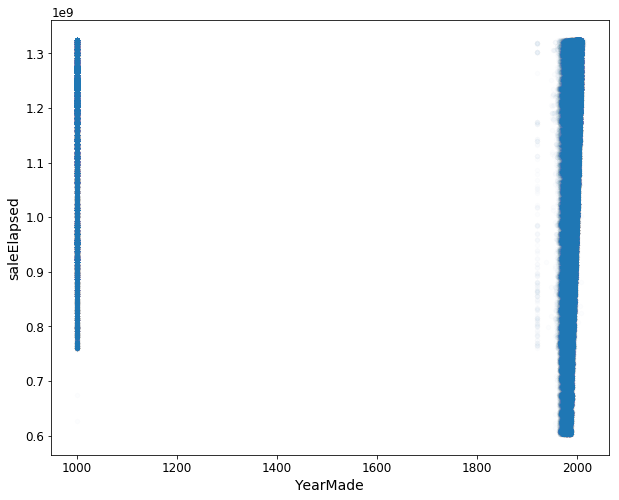

In [32]:
fit05.df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

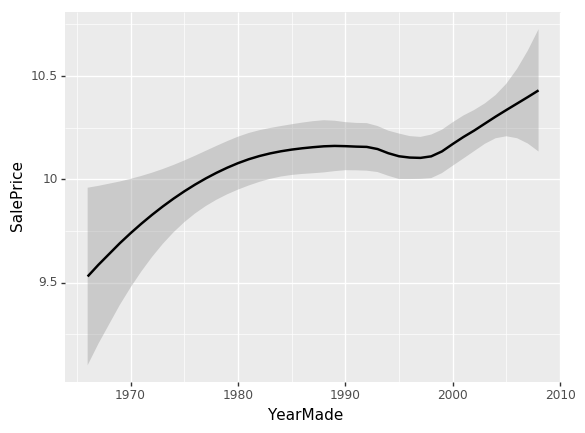

<ggplot: (8746542039293)>

In [33]:
x_all = get_sample(fit05.df_raw[lambda x: x.YearMade > 1930], 500)
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [34]:
def plot_pdp(m=None,
             x=None,
             feat=None,
             clusters=None,
             feat_name=None,
             figsize=(10,6)):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(
        p,
        feat_name,
        plot_lines=True,
        cluster=clusters is not None,
        n_cluster_centers=clusters,
        figsize=figsize)

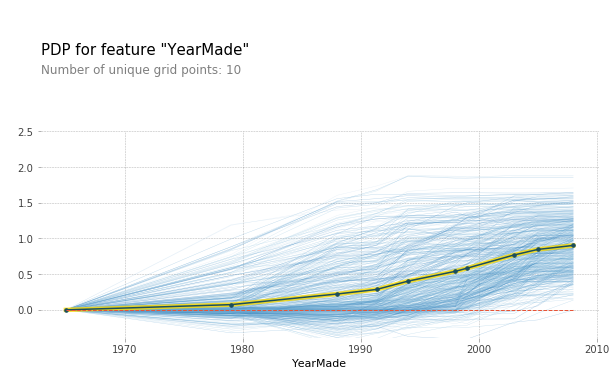

In [35]:
x = get_sample(fit05.X_train[fit05.X_train.YearMade > 1930], 500)
plot_pdp(fit05.m, x, 'YearMade');

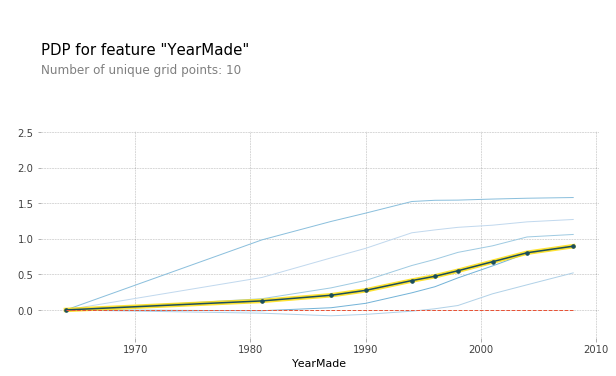

In [36]:
x = get_sample(fit05.X_train[fit05.X_train.YearMade > 1930], 500)
plot_pdp(fit05.m, x, 'YearMade', clusters=5);

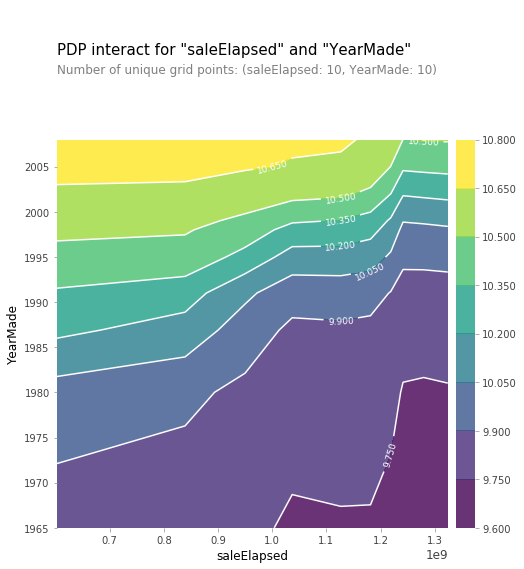

In [37]:
x = get_sample(fit05.X_train[fit05.X_train.YearMade > 1930], 500)
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(fit05.m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats, plot_pdp=False, plot_type='contour');

(<Figure size 720x432 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47691e63c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47691aca20>})

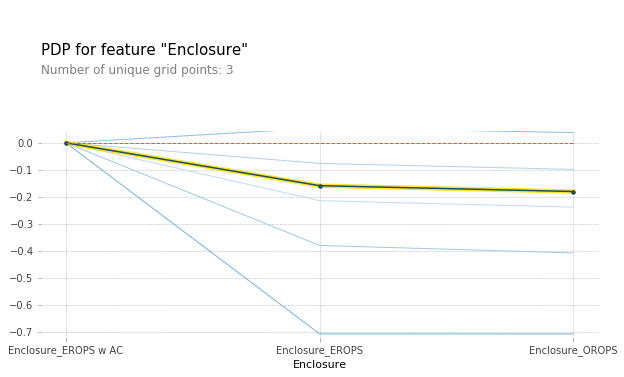

In [38]:
# def plot_pdp(m, x, feat, clusters=None, feat_name=None):
x = get_sample(fit05.X_train[fit05.X_train.YearMade > 1930], 500)
feat = ['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS']
plot_pdp(
    m=fit05.m, x=x, feat=feat, clusters=5, feat_name='Enclosure')

In [39]:
df_raw = fit05.df_raw.copy()
df_raw['YearMade'][df_raw['YearMade'] < 1950] = 1950
df_raw['age'] = df_raw.saleYear - df_raw.YearMade
df_raw.to_feather('tmp/bulldozers-raw-age')
DF_RAW_AGE = pd.read_feather('tmp/bulldozers-raw-age')
keep_cols = np.load('tmp/keep_cols.npy')
keep_cols_age = np.array(list(keep_cols) + ['age'])
np.save('tmp/keep_cols_age.npy', np.array(list(keep_cols) + ['age']))
keep_cols_age = np.load('tmp/keep_cols_age.npy')
dattr06 = do_proc_df(DF_RAW_AGE, N_VALID, 'SalePrice', to_keep=keep_cols_age)

samples: 50000
[0.22291 0.25928 0.89615 0.87995]


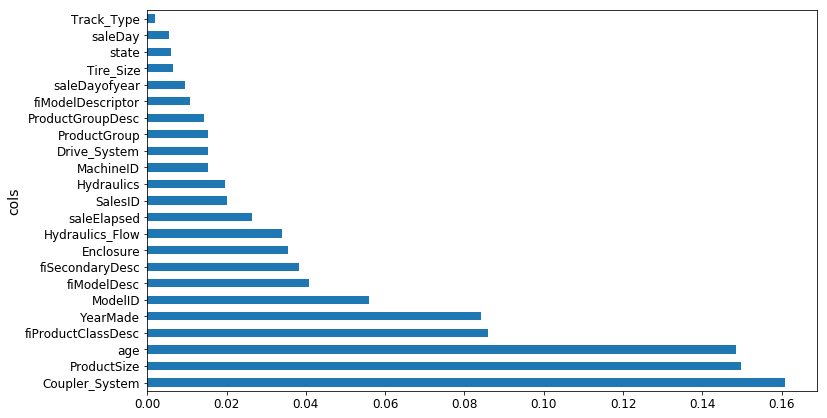

In [40]:
fit06 = rf_reg_fit(
    dattr06,
    n_samples=50_000,
    n_estimators=10,
    min_samples_leaf=5,
    max_features=0.6)
plot_fi(rf_feat_importance(fit06.m, fit06.df_trn))

# Tree interpreter

[andosa](https://github.com/andosa/treeinterpreter)

In [41]:
keep_cols_age = np.load('tmp/keep_cols_age.npy')
dattr07 = do_proc_df(DF_RAW_AGE, N_VALID, 'SalePrice', to_keep=keep_cols_age)
fit07 = rf_reg_fit(
    dattr07,
    n_samples=50_000,
    n_estimators=10,
    min_samples_leaf=5,
    max_features=0.6)

samples: 50000
[0.22222 0.25854 0.8968  0.88063]


In [42]:
row = dattr07.X_valid.values[0, np.newaxis]
print(row)
prediction, bias, contributions = ti.predict(fit07.m, row)
print(prediction, bias)
idxs = np.argsort(contributions[0])
pd.DataFrame([
    o for o in zip(fit07.X_train.columns[idxs], fit07.X_valid.iloc[0][idxs],
                   contributions[0][idxs])
],
             columns=['feature', 'value', 'change'])

[[      1999          0          5         17        665 1284595200          0          0          1
        3232          0    4364751    2300944          4          4          0         12         35
          16        259          0          2         11]]
[[9.33507]] [10.10638]


,feature,value,change
0,ProductSize,5,-0.52705
1,fiProductClassDesc,17,-0.20954
2,age,11,-0.09116
3,fiSecondaryDesc,0,-0.07401
4,Enclosure,1,-0.05896
5,fiModelDesc,3232,-0.04686
6,SalesID,4364751,-0.02982
7,Tire_Size,0,-0.02373
8,fiModelDescriptor,0,-0.01960
9,saleDayofyear,259,-0.01165


[https://github.com/chrispaulca/waterfall](https://github.com/chrispaulca/waterfall)

In [43]:
'%0.5f' % contributions.sum()

'-0.77131'

![waterfall from excel](https://i.imgur.com/cSZQHYb.png)

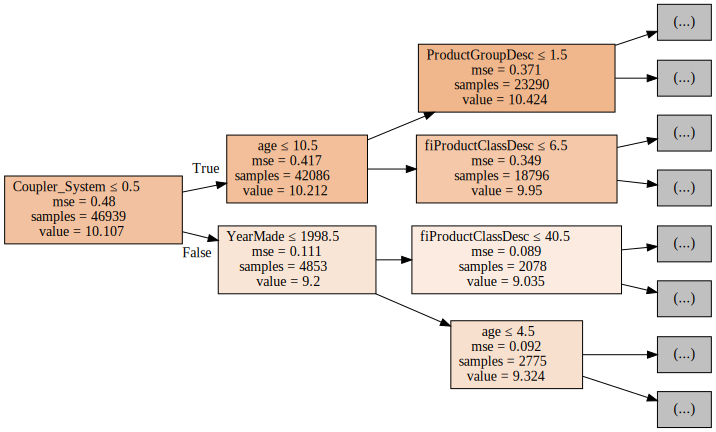

In [44]:
do_draw_tree(fit07.m.estimators_[0], fit07.df_trn)

# Extrapolation

In [45]:
keep_cols_age = np.load('tmp/keep_cols_age.npy')
df_ext = DF_RAW_AGE.copy()
df_ext = df_ext[keep_cols_age]
df_ext['is_valid'] = 0
df_ext['is_valid'][-N_VALID:] = 1
x, y, nas = proc_df(df_ext, 'is_valid')
m = RandomForestClassifier(
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.5,
    n_jobs=-1,
    oob_score=True)
m.fit(x, y)
print(m.oob_score_)
rf_feat_importance(m, x)[:10]

1.0


,cols,imp
11,SalesID,0.78674
5,saleElapsed,0.14075
12,MachineID,0.06134
19,saleDayofyear,0.00461
9,fiModelDesc,0.00204
4,ModelID,0.00193
0,YearMade,0.00146
8,Enclosure,0.00038
16,Hydraulics,0.00026
6,Hydraulics_Flow,0.00013


In [46]:
feats = rf_feat_importance(m, x).query('imp > 0.005').cols.values
(fit07.X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.00000,3.89125e+05,389125.00000
mean,1800.45249,1.08480e+06,1206.79615
std,595.62729,1.80391e+05,430.85055
min,1139.24600,6.00998e+05,0.00000
25%,1413.34800,9.66643e+05,1087.01600
50%,1632.09300,1.13460e+06,1273.85900
75%,2210.45300,1.23414e+06,1458.66100
max,4364.74100,1.32512e+06,2313.82100


In [47]:
(fit07.X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.00000,1.20000e+04,12000.00000
mean,5786.96765,1.30661e+06,1578.04971
std,836.89961,2.49781e+04,589.49717
min,4364.75100,1.17452e+06,0.83000
25%,4408.58075,1.30922e+06,1271.22525
50%,6272.53850,1.31604e+06,1825.31700
75%,6291.79225,1.32140e+06,1907.85800
max,6333.34200,1.32520e+06,2486.33000


In [48]:
x1 = x.drop(feats, axis=1)
m = RandomForestClassifier(
    n_estimators=40,
    min_samples_leaf=3,
    max_features=0.5,
    n_jobs=-1,
    oob_score=True)
m.fit(x1, y)
print(m.oob_score_)
rf_feat_importance(m, x1)[:10]

0.9817538173885946


,cols,imp
19,age,0.23260
0,YearMade,0.19875
16,saleDayofyear,0.16191
4,ModelID,0.06657
15,saleDay,0.06132
8,fiModelDesc,0.05552
14,state,0.05183
7,Enclosure,0.02888
3,fiProductClassDesc,0.02740
13,Hydraulics,0.02229


In [52]:
# %psearch x_*
# %xdel x_all

In [53]:
feats = [
    'SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear'
]
keep_cols_age = np.load('tmp/keep_cols_age.npy')
dattr08 = do_proc_df(DF_RAW_AGE, N_VALID, 'SalePrice', to_keep=keep_cols_age)

In [54]:
def test_drops(drop, dattr=dattr08):
    X_train = dattr.X_train.drop(drop, axis=1, errors='ignore')
    X_valid = dattr.X_valid.drop(drop, axis=1, errors='ignore')
    m = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=3,
        max_features=0.5,
        n_jobs=-1,
        oob_score=True)
    m.fit(X_train, dattr.y_train)
    print(drop)
    do_print_score(
        m,
        X_train=X_train,
        y_train=dattr.y_train,
        X_valid=X_valid,
        y_valid=dattr.y_valid)
    return AttrDict(locals())

In [55]:
with rf_samples(50_000):
    for f in (['All include:'] + feats):
        test_drops(f)

All include:
[0.20805 0.2489  0.90954 0.88937 0.89305]
SalesID
[0.20873 0.24493 0.90894 0.89286 0.89273]
saleElapsed
[0.21369 0.25457 0.90456 0.88427 0.88742]
MachineID
[0.20645 0.24505 0.91092 0.89276 0.89519]
age
[0.20896 0.24869 0.90874 0.88955 0.89217]
YearMade
[0.20881 0.25119 0.90888 0.88732 0.89225]
saleDayofyear
[0.20862 0.2441  0.90904 0.89359 0.89292]


In [56]:
out = None
with rf_samples('all'):
    for f in (['All include:', ['SalesID', 'MachineID', 'saleDayofyear']]):
        out = test_drops(f)

All include:
[0.12529 0.22579 0.96719 0.90896 0.90864]
['SalesID', 'MachineID', 'saleDayofyear']
[0.13745 0.21885 0.96052 0.91446 0.90929]


In [57]:
np.save('tmp/keep_cols_final.npy', out.X_train.columns)
out.X_train.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'Hydraulics_Flow', 'fiSecondaryDesc',
       'Enclosure', 'fiModelDesc', 'fiModelDescriptor', 'ProductGroup',
       'ProductGroupDesc', 'Tire_Size', 'Hydraulics', 'state', 'saleDay',
       'Drive_System', 'Track_Type', 'age'],
      dtype='object')

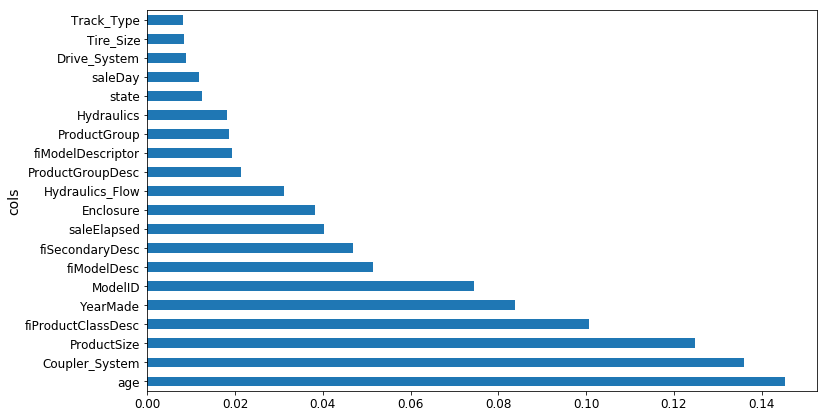

In [58]:
plot_fi(rf_feat_importance(out.m, out.X_train));

# Our final model

In [59]:
keep_cols_final = np.load('tmp/keep_cols_final.npy')
dattr09 = do_proc_df(
    DF_RAW_AGE, N_VALID, y_fld='SalePrice', to_keep=keep_cols_final)


In [60]:
gc.collect()

4043

In [61]:
%%time
fit09 = rf_reg_fit(
    dattr09,
    n_estimators=160,
    max_features=0.5,
    oob_score=True)

samples: all
[0.08006 0.21122 0.98661 0.92033 0.91456]
CPU times: user 5min 5s, sys: 4.23 s, total: 5min 9s
Wall time: 1min


# The End